## - Import

In [37]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch
import numpy as np 
import pandas as pd  
import os 
from torchvision.datasets import SVHN 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from tqdm import tqdm


import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.0.0+cu117
device: cuda


## - Parameters

In [39]:
transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [40]:
train_dataset=SVHN(split='train',root='data/train',transform=transform)
# test_dataset=SVHN(split='test',root='data/test',transform=transform)



In [54]:
class_list = {'0','1','2','3','4','5','6','7','8','9'}

In [41]:
# Data


img_size = 32 # Image size
batch_size = 64  # Batch size

# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# Training
epochs = 30  # Train epochs
learning_rate = 1e-4
class_num=10

## - Pytorch Dataset, DataLoader: Fashion MNIST

In [43]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
# val_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

In [44]:
a,b=next(iter(train_loader))
a.shape

torch.Size([64, 1, 32, 32])

## - Generator

In [45]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        self.label_emb = nn.Embedding(class_num, class_num)
        
        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        
        # Reshape z
        z = z.view(-1, self.z_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([z, c], 1)
        
        # Generator out
        out = self.model(x)
        
        return out.view(-1, self.img_size, self.img_size)

## - Discriminator

In [46]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        
        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        
        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([x, c], 1)
        
        # Discriminator out
        out = self.model(x)
        
        return out.squeeze()

In [47]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

## - Adversarial Learning of Generator & Discriminator

In [48]:
# Loss function
criterion = nn.BCELoss()

In [49]:
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [50]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    
    # Init gradient
    g_optimizer.zero_grad()
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    
    # Backword propagation
    g_loss.backward()
    
    #  Optimizing generator
    g_optimizer.step()
    
    return g_loss.data

In [51]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    
    # Init gradient 
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)
    
    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    # Sum two losses
    d_loss = real_loss + fake_loss
    
    # Backword propagation
    d_loss.backward()
    
    # Optimizing discriminator
    d_optimizer.step()
    
    return d_loss.data

Starting epoch 1...
g_loss: 3.221221923828125, d_loss: 0.612774133682251


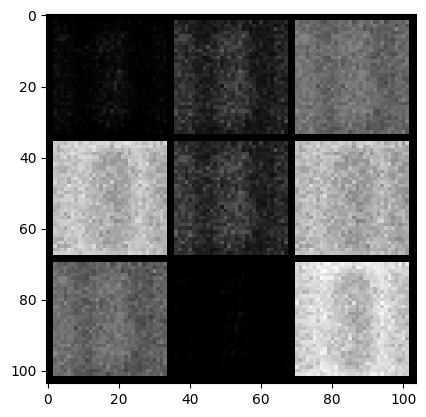

Starting epoch 2...
g_loss: 2.1933515071868896, d_loss: 0.5879708528518677


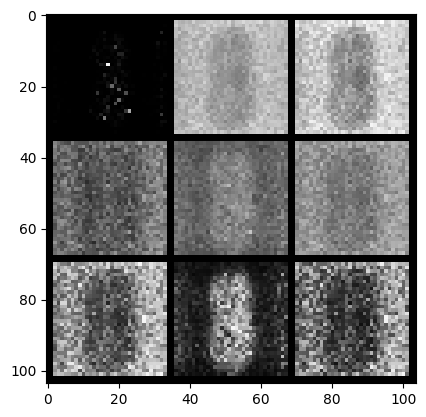

Starting epoch 3...
g_loss: 1.259087324142456, d_loss: 0.7554041147232056


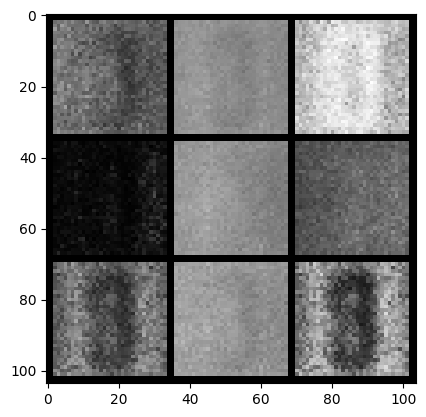

Starting epoch 4...
g_loss: 1.2599236965179443, d_loss: 1.0374503135681152


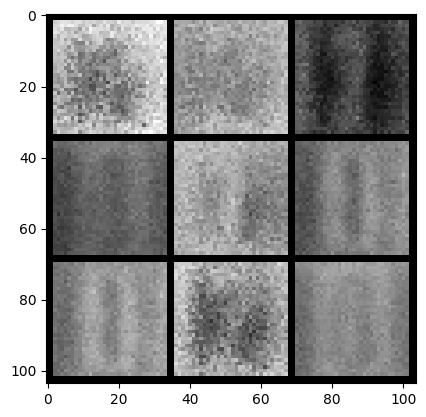

Starting epoch 5...
g_loss: 1.2260499000549316, d_loss: 1.3835647106170654


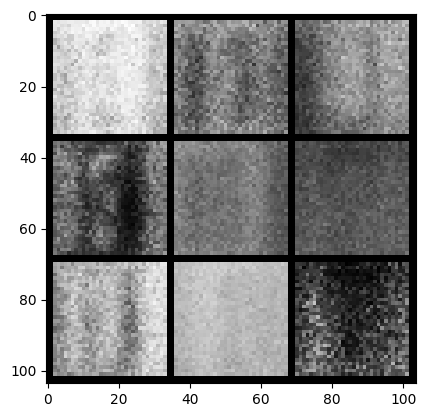

Starting epoch 6...
g_loss: 1.1147663593292236, d_loss: 0.9632788896560669


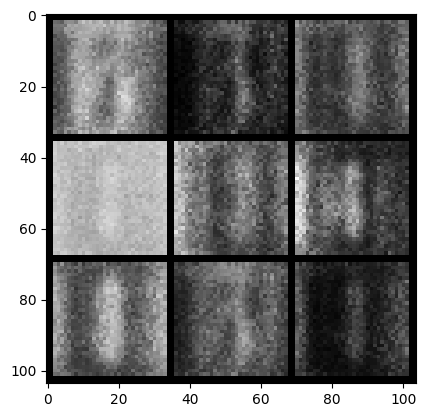

Starting epoch 7...
g_loss: 1.1840770244598389, d_loss: 0.9504213333129883


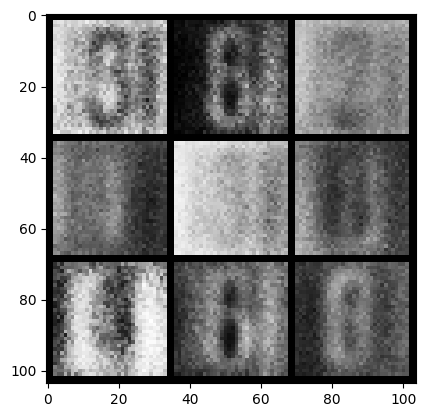

Starting epoch 8...
g_loss: 1.0864887237548828, d_loss: 1.439655065536499


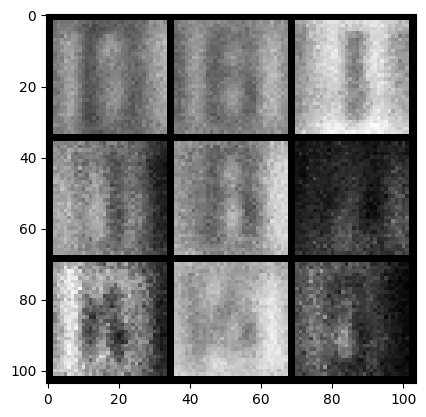

Starting epoch 9...
g_loss: 1.0722670555114746, d_loss: 1.2279613018035889


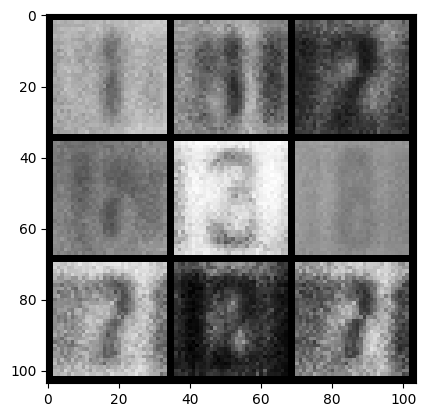

Starting epoch 10...
g_loss: 1.0918889045715332, d_loss: 0.9945998191833496


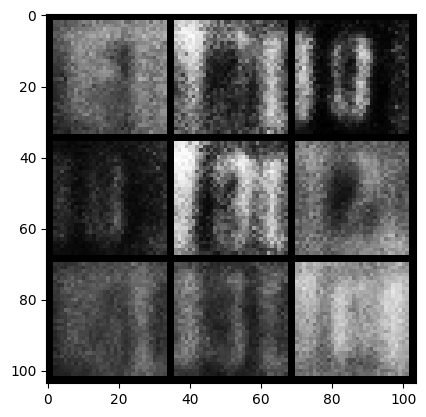

Starting epoch 11...
g_loss: 0.9319660663604736, d_loss: 1.058976173400879


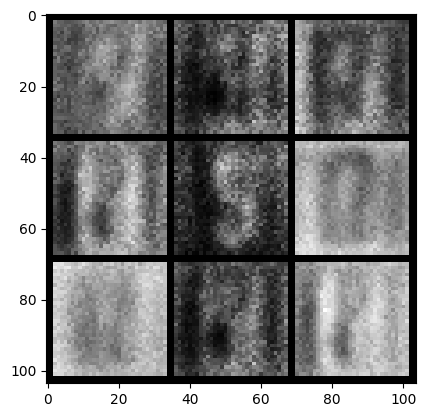

Starting epoch 12...
g_loss: 1.0586528778076172, d_loss: 1.1557806730270386


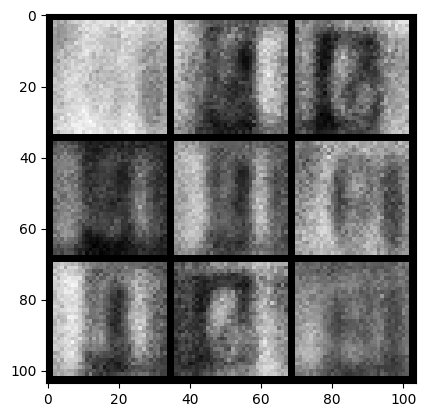

Starting epoch 13...
g_loss: 0.9102247357368469, d_loss: 1.2419989109039307


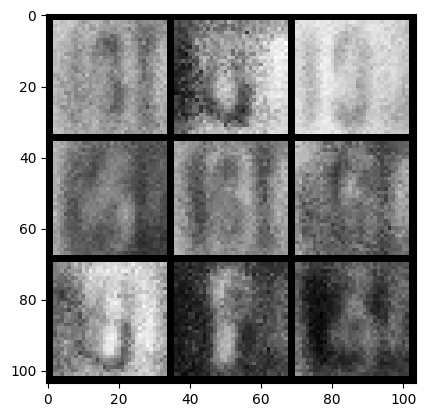

Starting epoch 14...
g_loss: 0.8093392848968506, d_loss: 1.6389719247817993


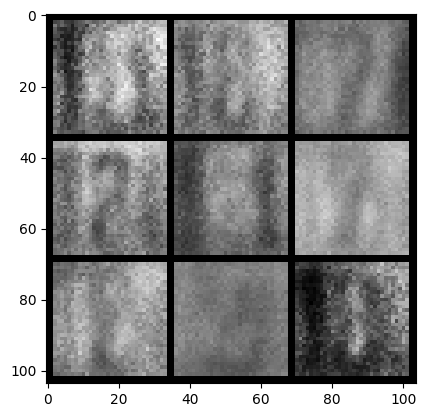

Starting epoch 15...
g_loss: 0.9102205038070679, d_loss: 1.3730559349060059


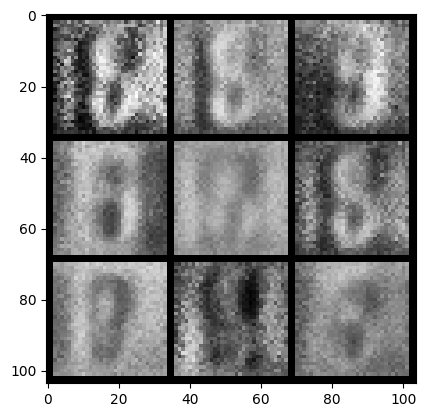

Starting epoch 16...
g_loss: 0.7780594229698181, d_loss: 1.2043436765670776


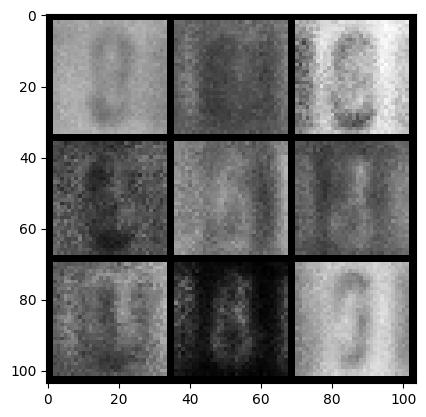

Starting epoch 17...
g_loss: 1.1603734493255615, d_loss: 1.0922895669937134


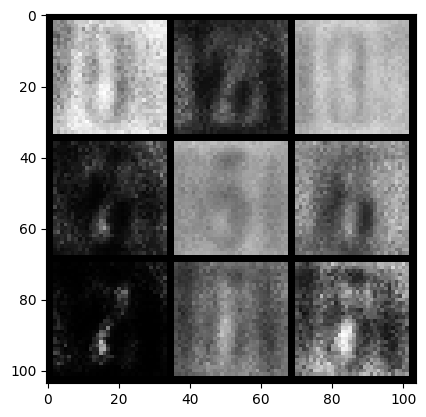

Starting epoch 18...
g_loss: 0.9522771835327148, d_loss: 1.3530066013336182


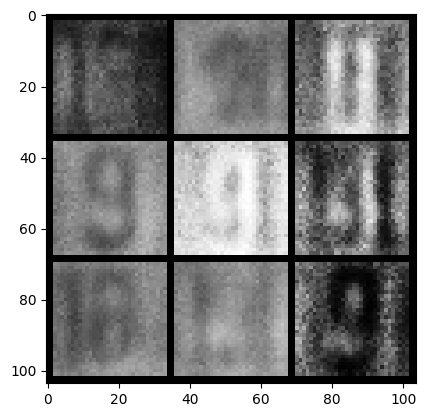

Starting epoch 19...
g_loss: 0.9128423929214478, d_loss: 1.308040976524353


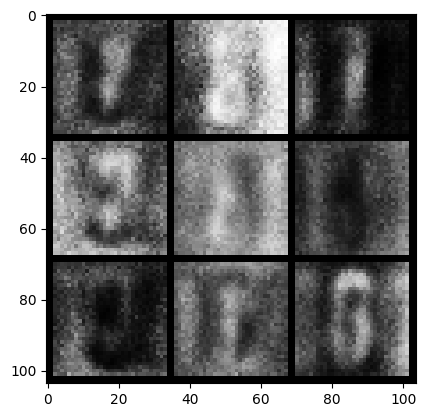

Starting epoch 20...
g_loss: 0.8464837074279785, d_loss: 1.2478041648864746


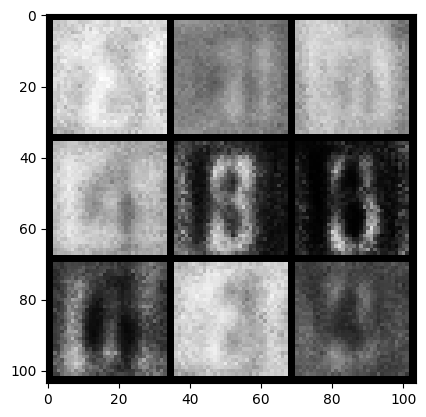

Starting epoch 21...
g_loss: 0.9262004494667053, d_loss: 1.2733354568481445


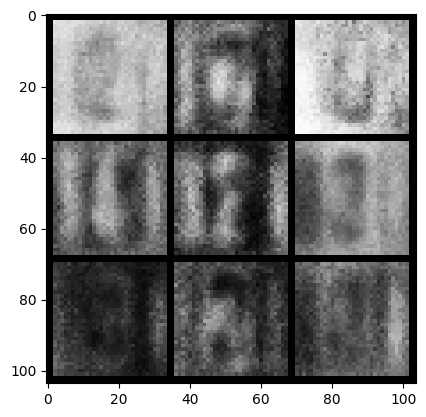

Starting epoch 22...
g_loss: 0.9009517431259155, d_loss: 1.3335926532745361


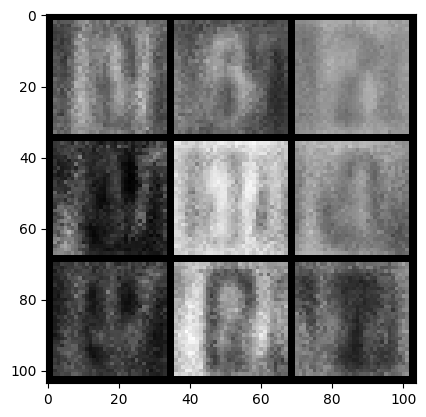

Starting epoch 23...
g_loss: 0.8428680300712585, d_loss: 1.1648714542388916


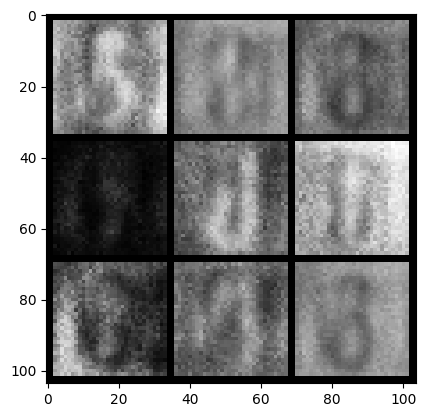

Starting epoch 24...
g_loss: 0.8661541938781738, d_loss: 1.3969916105270386


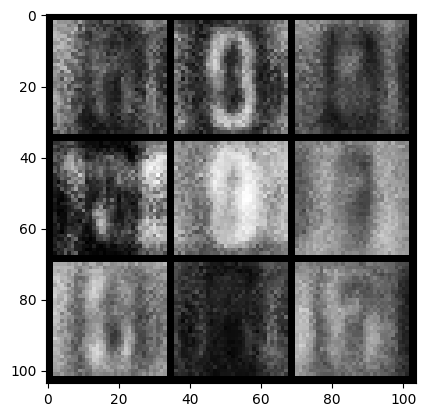

Starting epoch 25...
g_loss: 0.893254816532135, d_loss: 1.2011077404022217


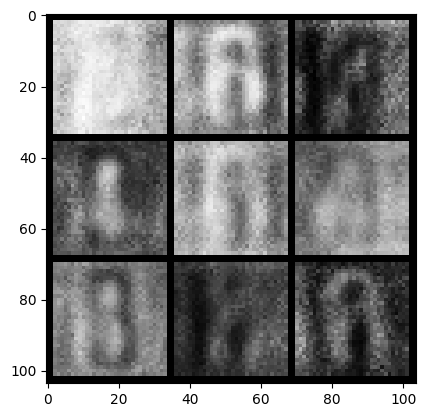

Starting epoch 26...
g_loss: 0.9138593077659607, d_loss: 1.2859907150268555


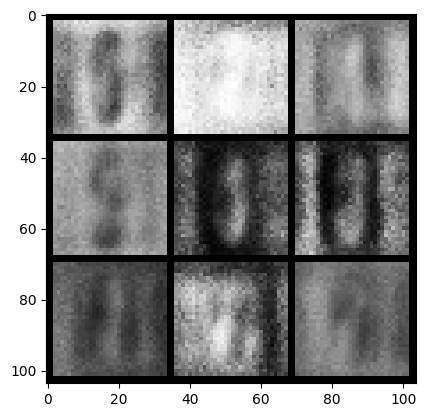

Starting epoch 27...
g_loss: 0.9961706399917603, d_loss: 1.182995080947876


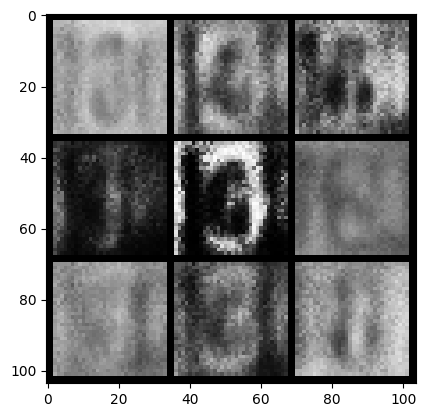

Starting epoch 28...
g_loss: 0.8082802295684814, d_loss: 1.4479585886001587


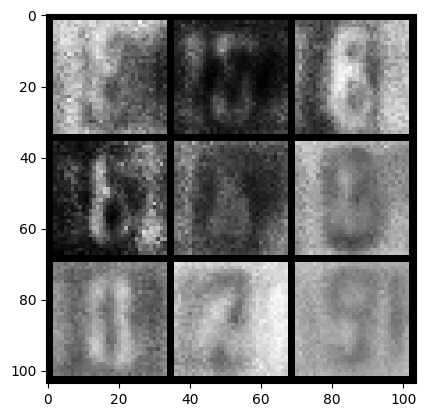

Starting epoch 29...
g_loss: 0.8531041145324707, d_loss: 1.2731415033340454


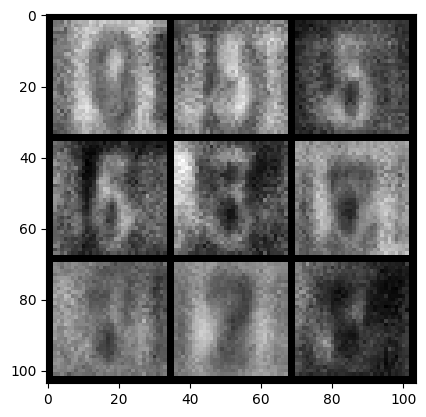

Starting epoch 30...
g_loss: 0.903337836265564, d_loss: 1.3815003633499146


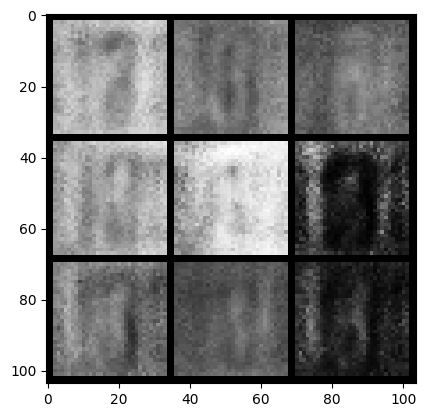

In [52]:
for epoch in range(epochs):
    
    print('Starting epoch {}...'.format(epoch+1))
    
    for i, (images, labels) in enumerate(train_loader):
        
        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        
        # Set generator train
        generator.train()
        
        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        
        # Train generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
    
    # Set generator eval
    generator.eval()
    
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    
    # Building z 
    z = Variable(torch.randn(class_num-1, z_size)).to(device)
    
    # Labels 0 ~ 8
    labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)
    
    # Generating images
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    
    # Show images
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

## - Show Generating Images

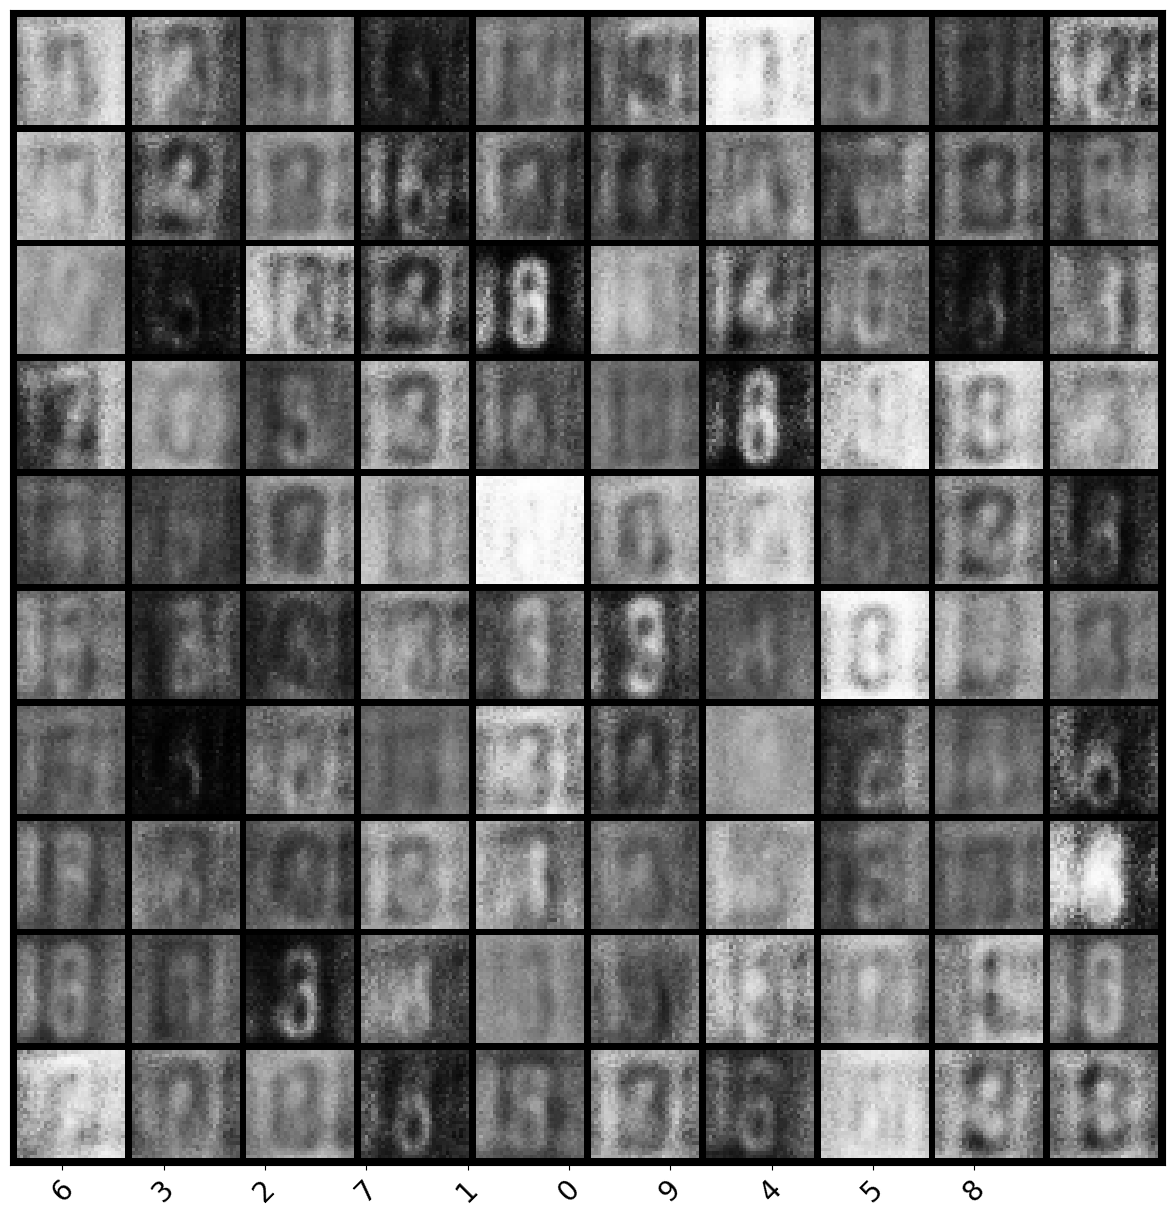

In [55]:
# Building z 
z = Variable(torch.randn(z_size, z_size)).to(device)

# Labels 0 ~ 9
labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)

# Generating images
sample_images = generator(z, labels).unsqueeze(1).data.cpu()

# Show images
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), class_list, rotation=45, fontsize=20)